In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import cairo
import numpy as np
import PIL
import ot
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [3]:
class Synthetic:
    def __init__(self, MAX_X=28, MAX_Y=28, border=4):
        self.MAX_X = MAX_X
        self.MAX_Y = MAX_Y
        self.border = border

    def random_line(self, ctx):
        x = []
        y = []
        for it in range(2):
            x.append(np.random.randint(self.border, self.MAX_X - self.border))
            y.append(np.random.randint(self.border, self.MAX_Y - self.border))
            
        return self.line(ctx, x, y)
        
    def line(self, ctx, x, y):
        ctx.move_to(x[0], y[0])
        ctx.line_to(x[1], y[1])

        ctx.set_line_join(cairo.LINE_JOIN_MITER)
        ctx.set_line_cap(cairo.LINE_CAP_BUTT)

        ctx.stroke()
        ctx.close_path()
        if (x[0], y[0]) < (x[1], y[1]):
            return x[0], y[0], x[1], y[1]
        else:
            return x[1], y[1], x[0], y[0]

    def get_image(self, img_path='../data/Synthetic/', name='1', line_count=2):
        ps = cairo.SVGSurface(img_path + name + "svgfile1.svg", self.MAX_X, self.MAX_Y)
        ctx = cairo.Context(ps)
        ctx.save()
        ctx.set_source_rgb(0, 0, 0)
        ctx.paint()
        ctx.restore()
        ctx.move_to(0, 0)
        mass = []
        for it in range(line_count):
            width = np.random.randint(1, 6)
            ctx.set_line_width(width)
            ctx.set_source_rgba(1, 1, 1, 1)
            mass.append(self.random_line(ctx) + (width,))
        mass.sort()
        ctx.set_operator(cairo.OPERATOR_MULTIPLY)
        ps.write_to_png(img_path + name + '_nh_gt.png')
        image = Image.open(img_path + name + '_nh_gt.png')
        inverted_image = PIL.ImageOps.invert(image)
        inverted_image = inverted_image.convert('L')
        inverted_image.save(img_path + name + '_nh_gt.png')

        return inverted_image, mass

    def r_line(self, ctx, ln):
        ctx.new_sub_path()
        ctx.save()
        ctx.move_to(ln[0], ln[1])
        ctx.line_to(ln[2], ln[3])

        ctx.set_line_join(cairo.LINE_JOIN_MITER)
        ctx.set_line_cap(cairo.LINE_CAP_SQUARE)

        ctx.stroke()
        ctx.close_path()
        ctx.restore()

    def render(self, lines, img_path='../data/Synthetic/', name='1'):
        ps = cairo.SVGSurface(img_path + name + "svgfile1.svg", self.MAX_X, self.MAX_Y)
        ctx = cairo.Context(ps)
        ctx.save()
        ctx.set_source_rgb(0, 0, 0)
        ctx.paint()
        ctx.restore()
        ctx.move_to(0, 0)

        for ln in lines:
            if ln[-1] < 0.5:
                continue
            width = ln[4]
            ctx.set_line_width(width)
            ctx.set_source_rgba(1, 1, 1, 1)

            self.r_line(ctx, ln)

        ctx.set_operator(cairo.OPERATOR_MULTIPLY)
        ps.write_to_png(img_path + name + '_nh_gt.png')
        image = Image.open(img_path + name + '_nh_gt.png')
        inverted_image = PIL.ImageOps.invert(image)
        inverted_image = inverted_image.convert('L')
        inverted_image.save(img_path + name + '_nh_gt.png')

        return inverted_image

In [4]:
def line_to_coords_and_mass(line):
    """
    Returns (x_center, y_center, normal_slope, mass)
    """
    x0, y0, x1, y1, width = line
    mass = np.sum(1 - np.array(Synthetic(64, 64).render([line], '.')) / 255)
    x_center, y_center = (x1 + x0) / 2, (y1 + y0) / 2
    
    if y1 == y0:
        angle = 0.0
    else:
        angle = np.arctan((y1 - y0) / float(x1 - x0))
        if angle < 0:
            angle = np.pi + angle
    
    return (x_center, y_center), mass

In [5]:
def spread_out_coords_and_mass(line, n_points=4):
    x0, y0, x1, y1, width = line
    (x_center, y_center), mass = line_to_coords_and_mass(line)
    
    x_linspace = np.linspace(x0, x1, n_points)
    y_linspace = np.linspace(y0, y1, n_points)
    
    return np.vstack((x_linspace, y_linspace)).T, np.full((n_points, ), mass / n_points)


In [6]:
def spread_masses(plines, n_points_per_line=8):

    line_coords = np.zeros((n_points_per_line * len(plines), 2))
    line_masses = np.zeros((n_points_per_line * len(plines,)))

    for i, line in enumerate(plines):
        coords, masses = spread_out_coords_and_mass(line, n_points_per_line)

        line_coords[i * n_points_per_line : (i + 1) * n_points_per_line] = coords
        line_masses[i * n_points_per_line : (i + 1) * n_points_per_line] = masses
        
    return line_coords, line_masses

In [7]:
def render_pimage_from_plines(synthetic, plines):
    pimage = 1 - np.array(synthetic.render(plines, '.')) / 255
    return pimage

In [8]:
def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [10]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density

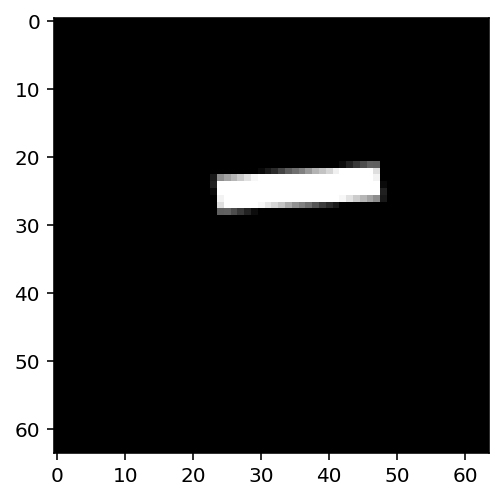

In [11]:
s = Synthetic(64, 64)

np.random.seed(111)

image, lines = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255
plt.imshow(image, cmap='gist_gray')
plt.show()

14.995340296677908
14.491379581989307
14.073211890449285
13.729227625624244
13.453076178122604
13.239464928472762
13.083745171768626
12.981532462169774
12.929726044210252
12.924312096896957
12.962592928699008
13.041457278368286
13.159011098140715
13.315327646184288
13.51231551043162
13.752720287486094
14.03998170878019
14.378656991601531
14.772680420029142
15.227402390580732
15.751078313088879


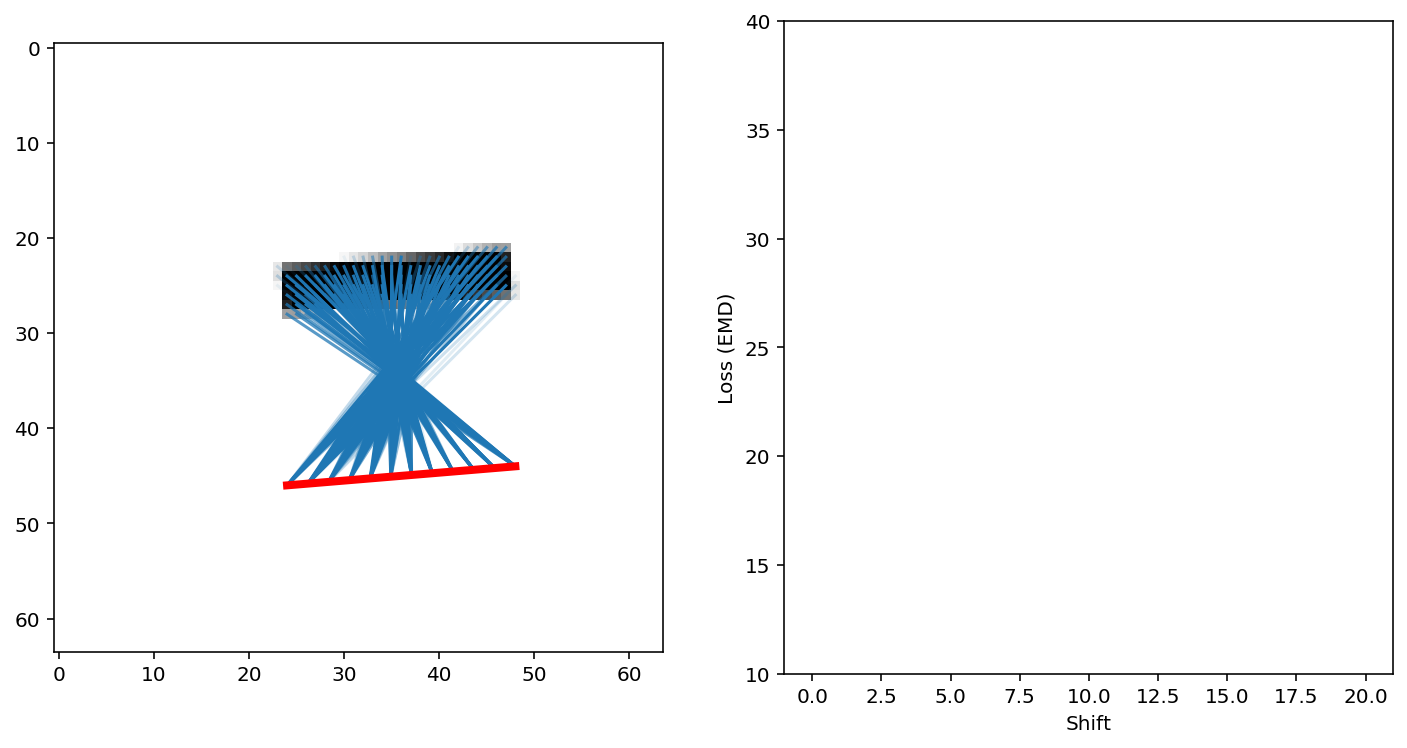

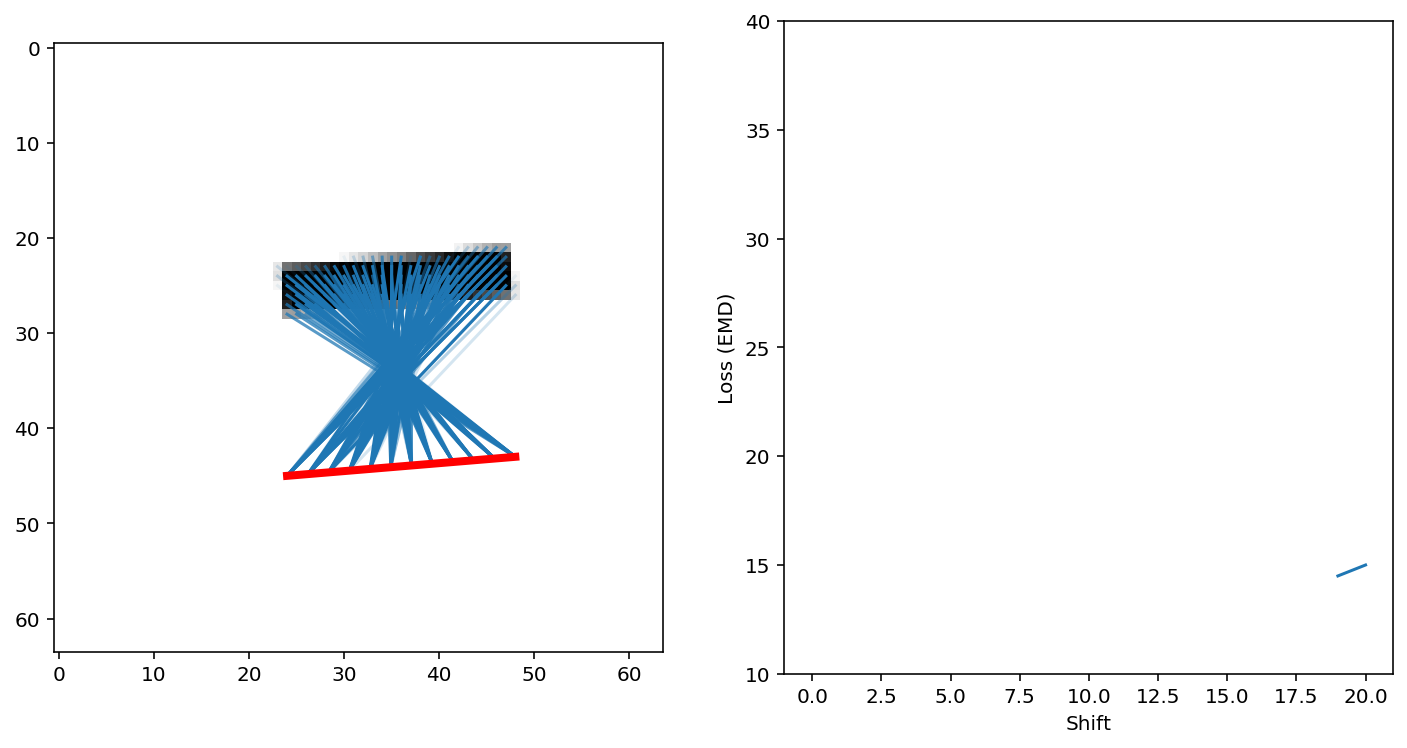

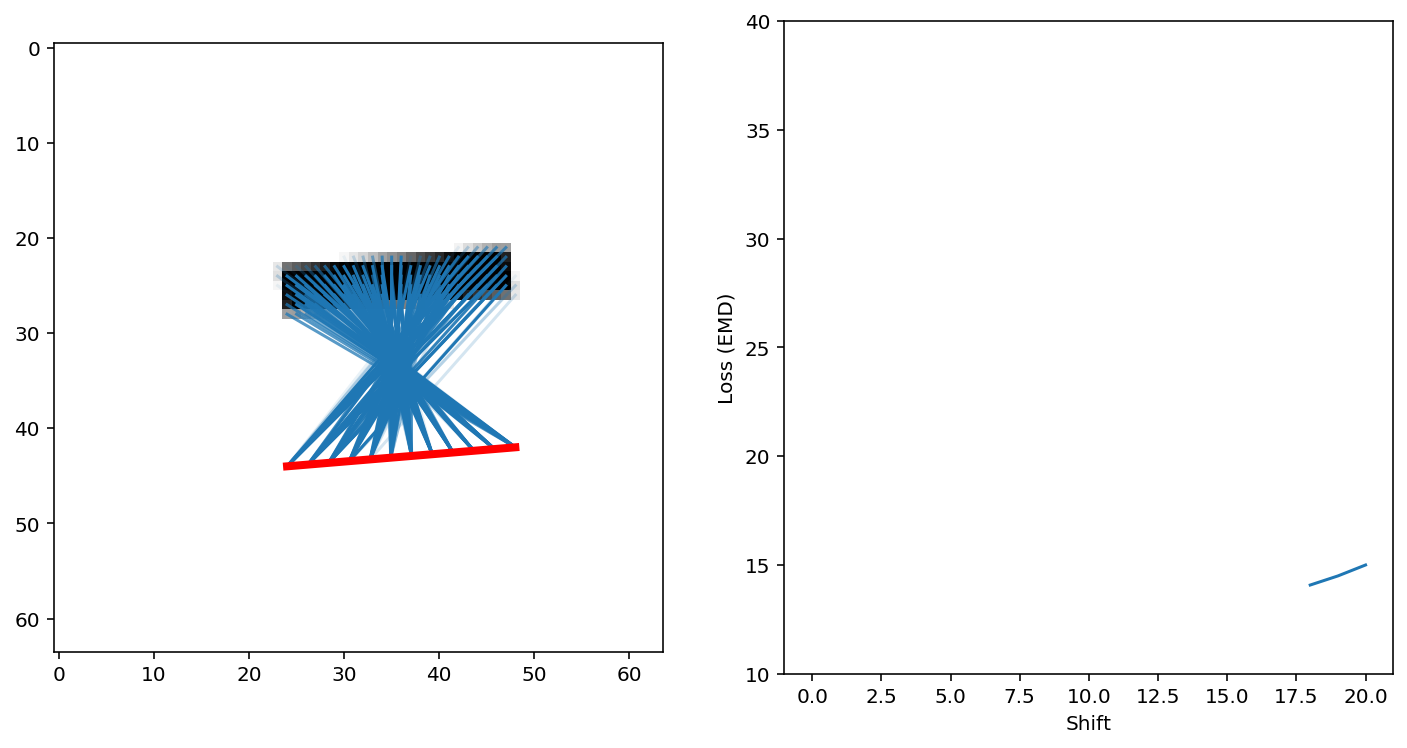

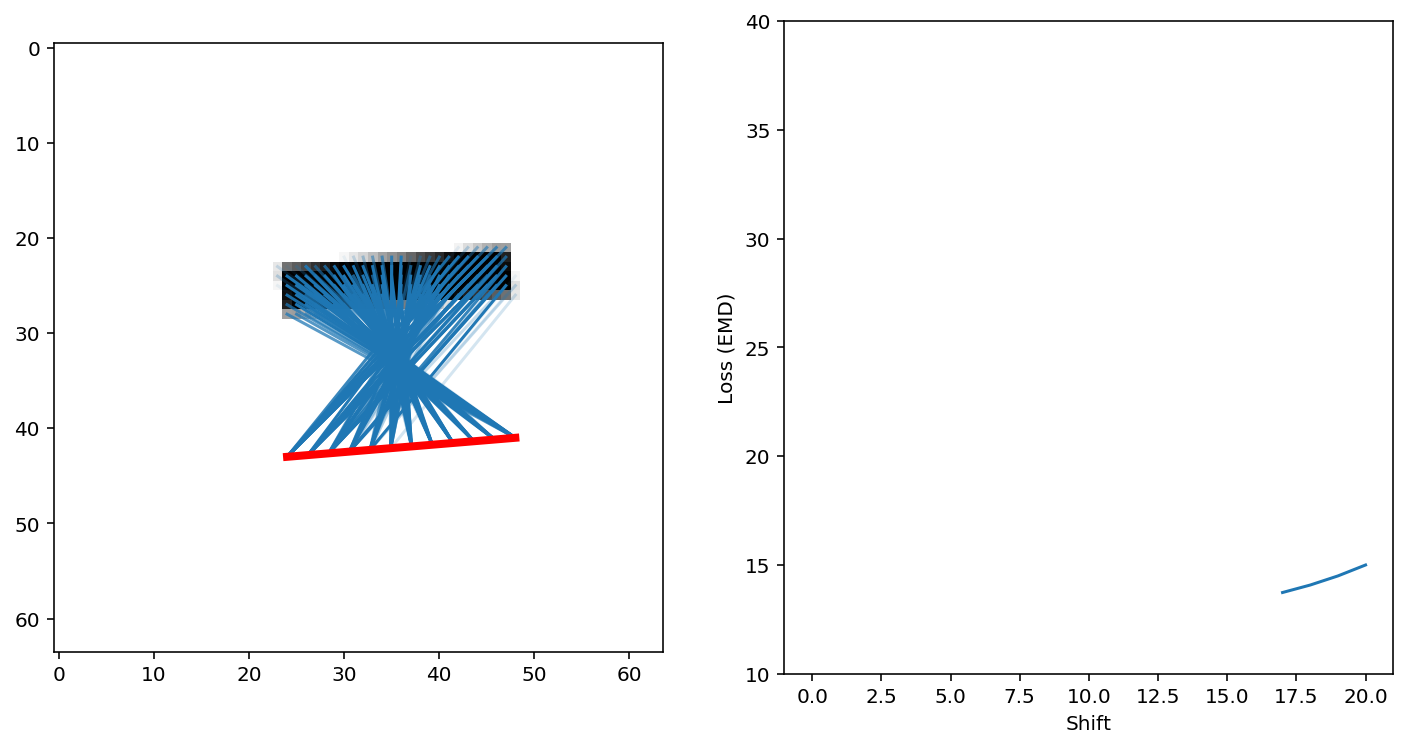

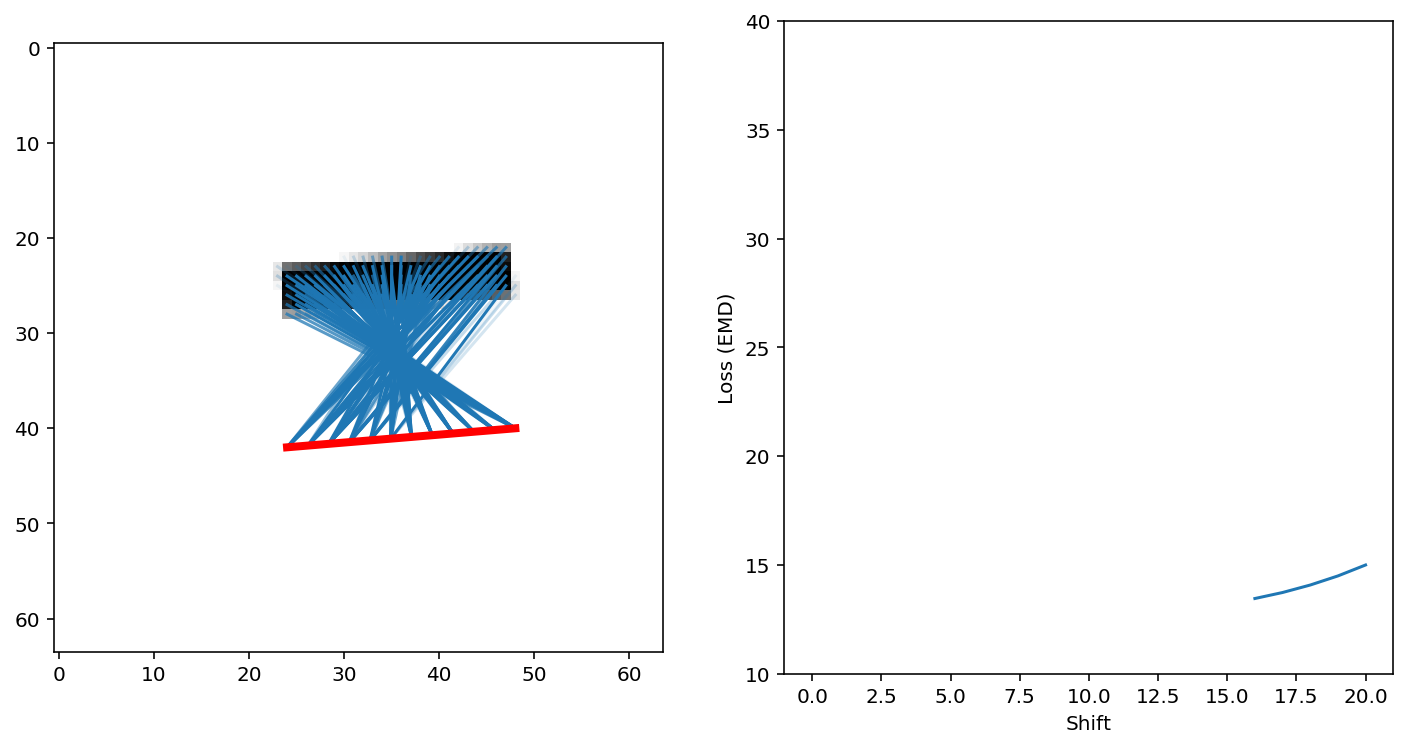

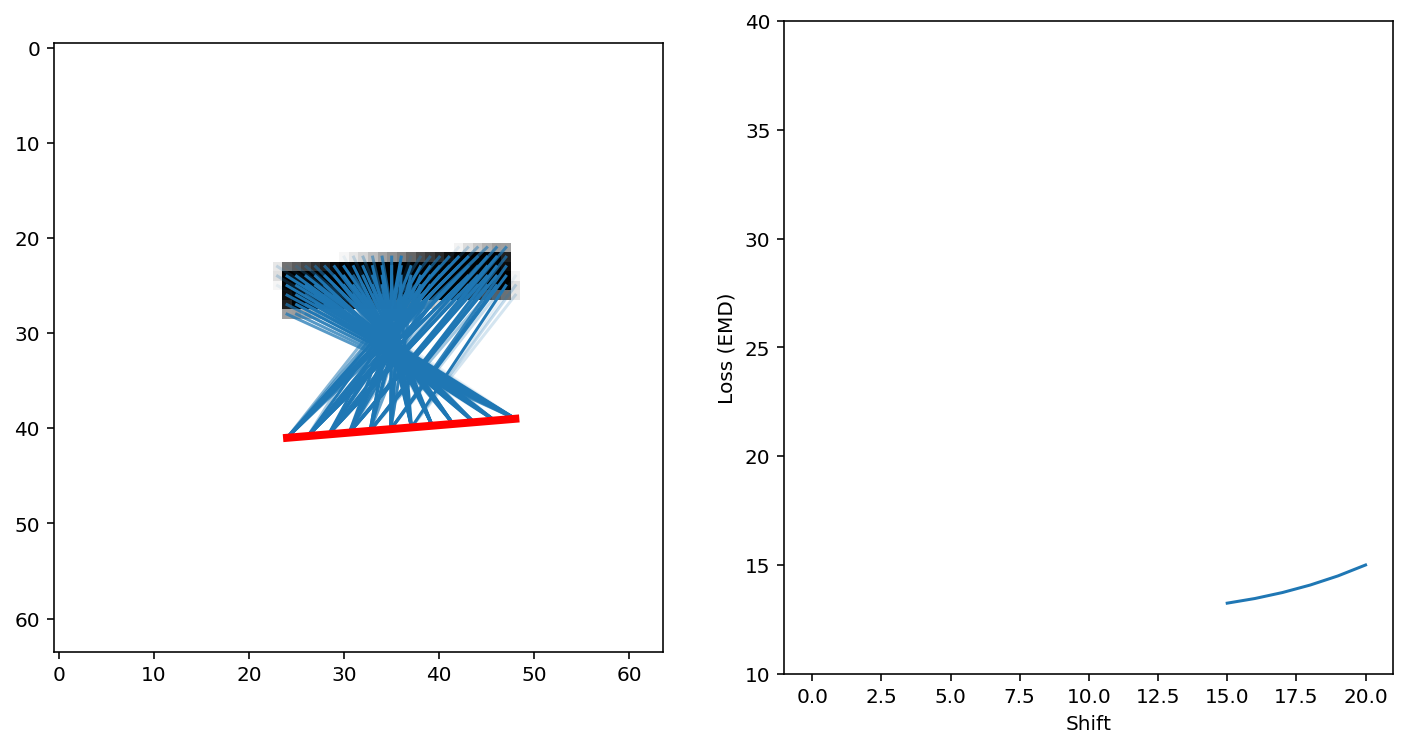

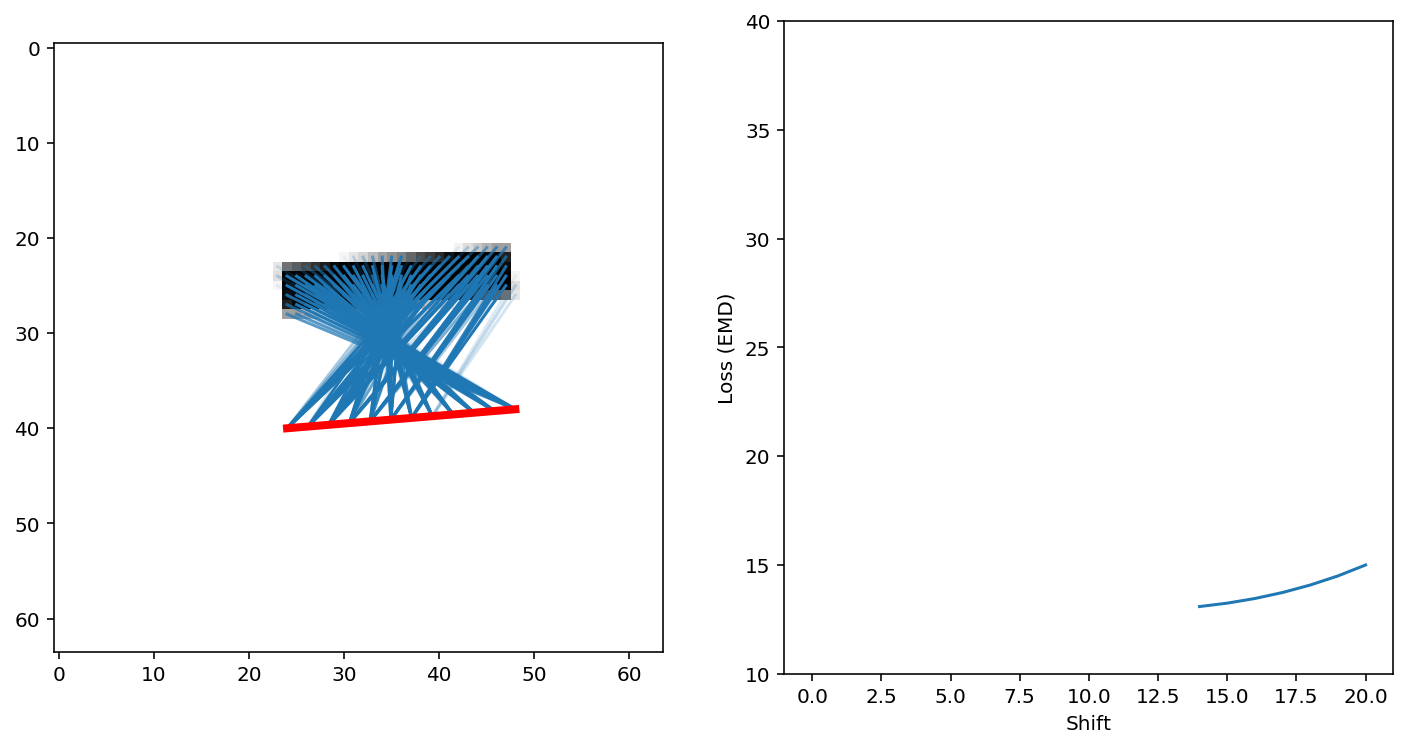

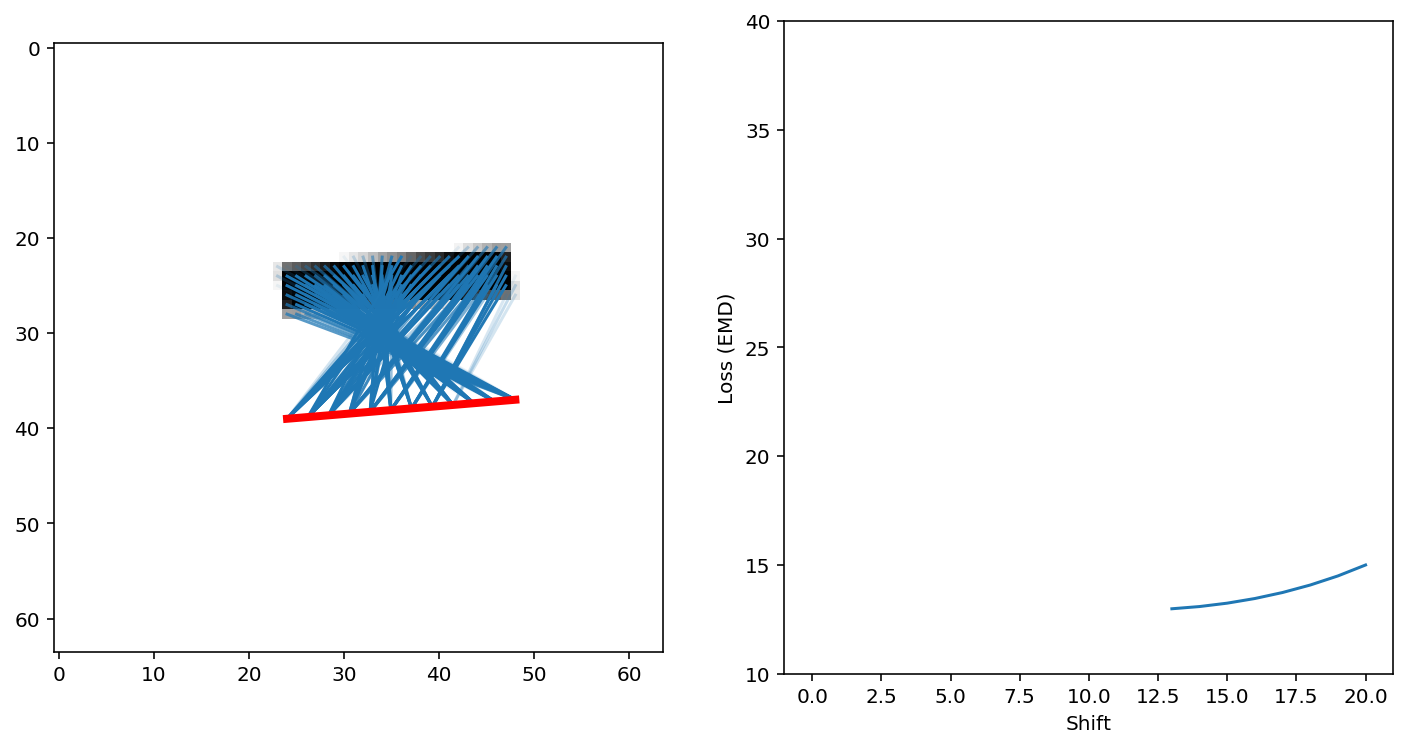

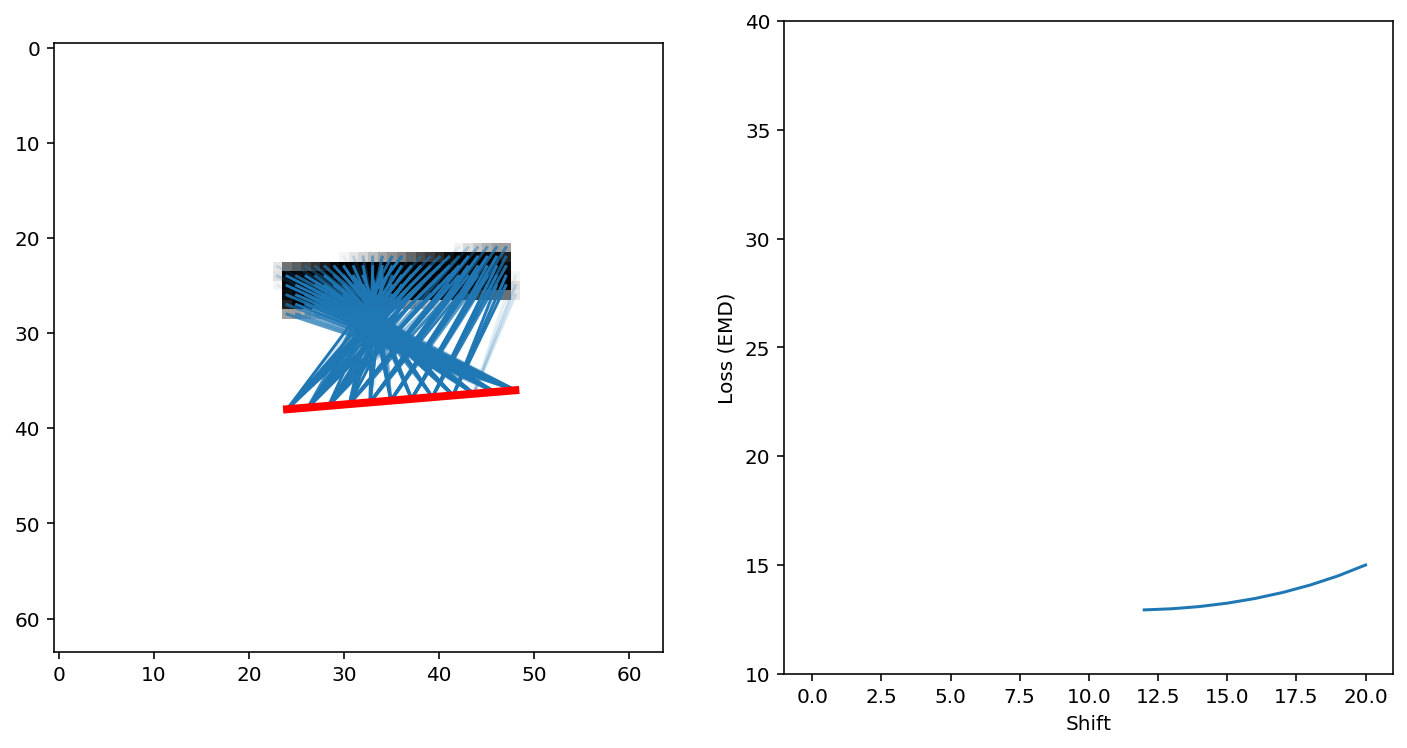

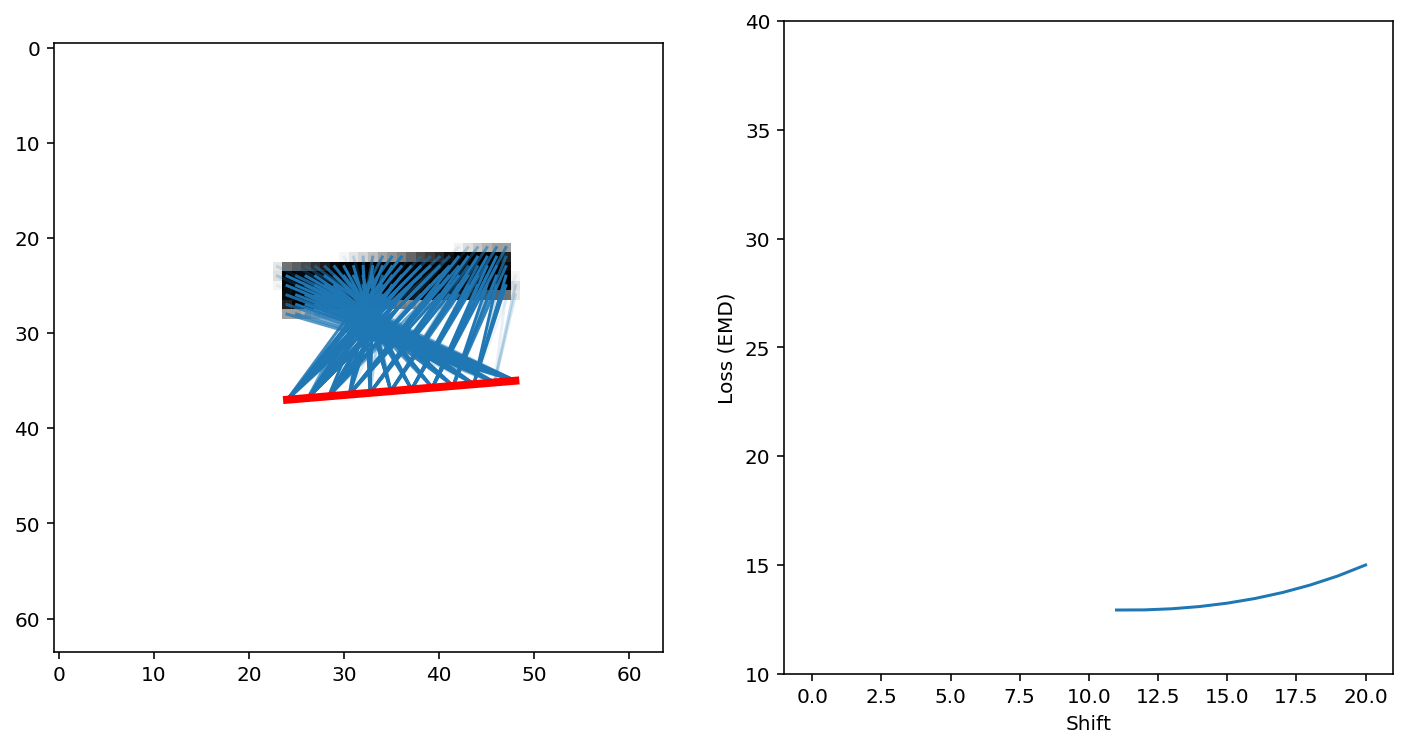

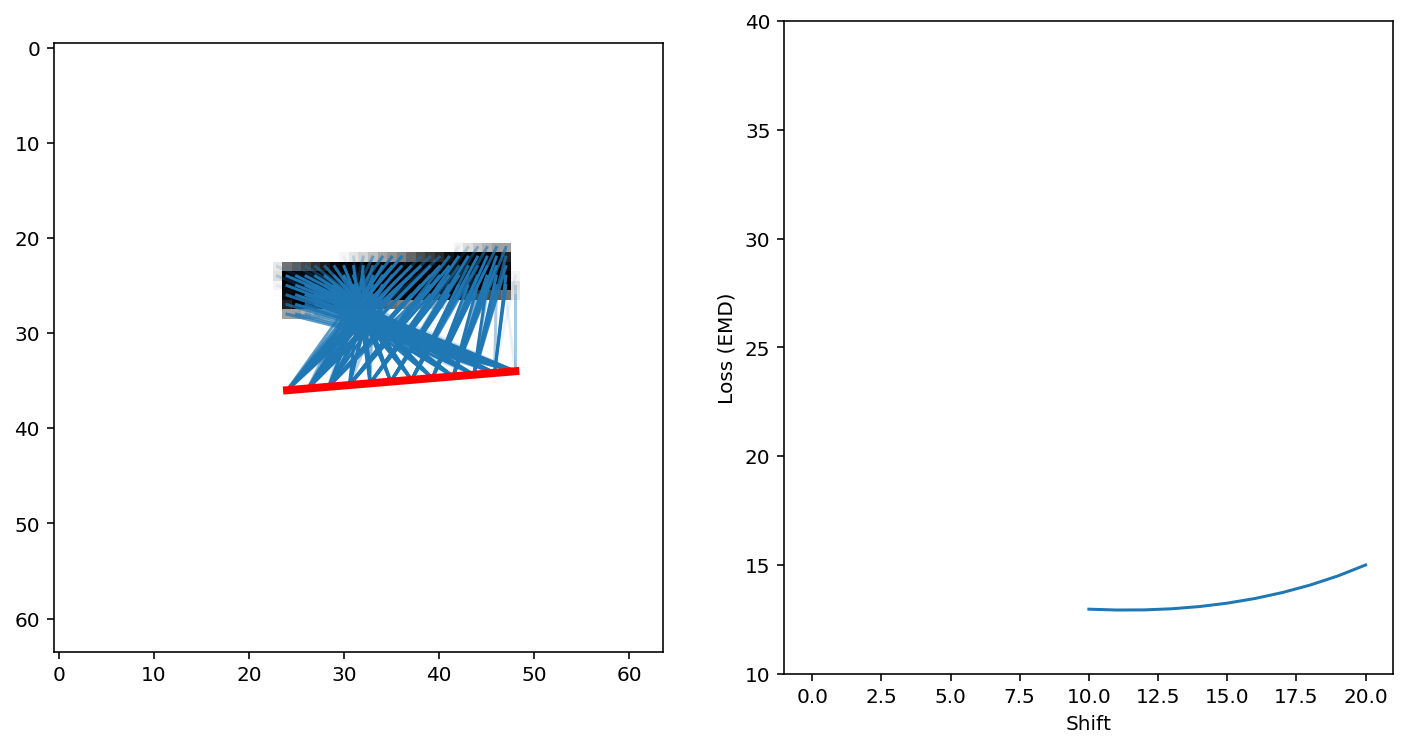

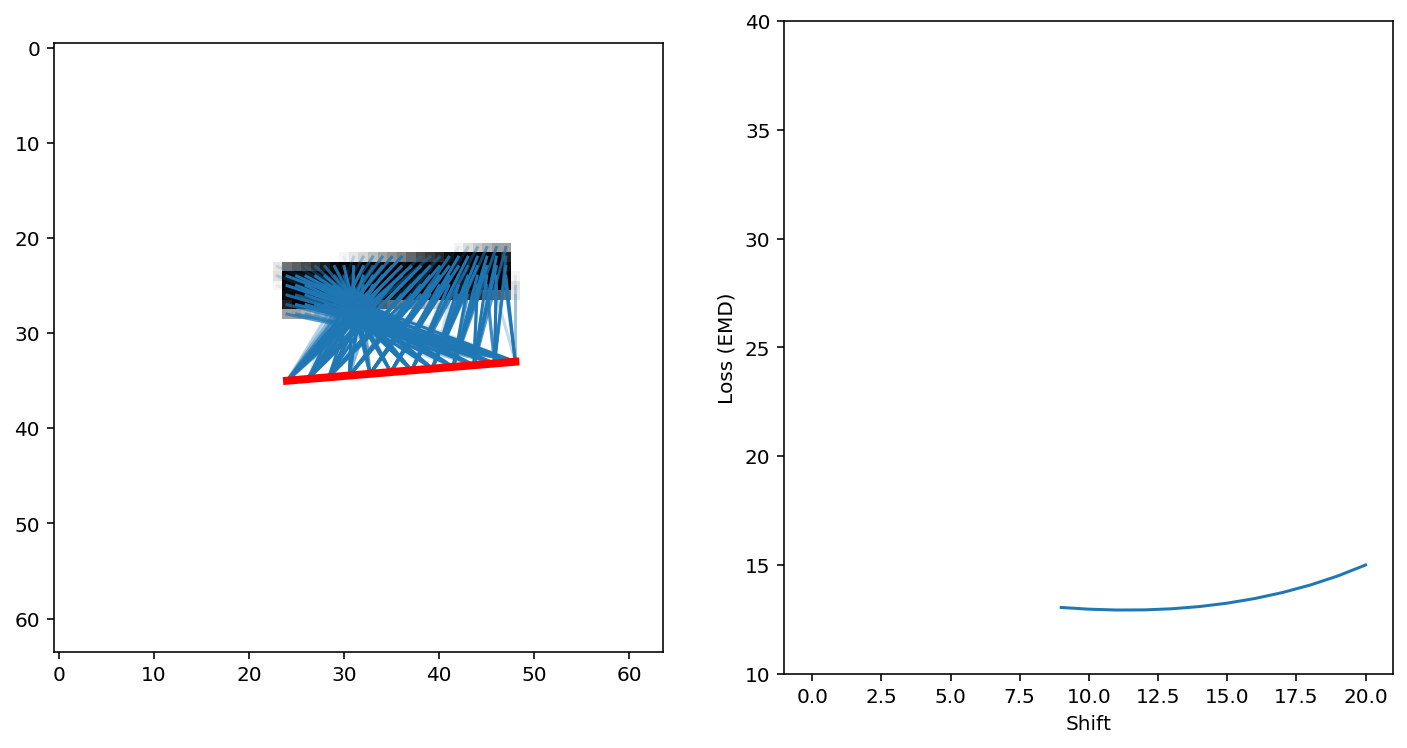

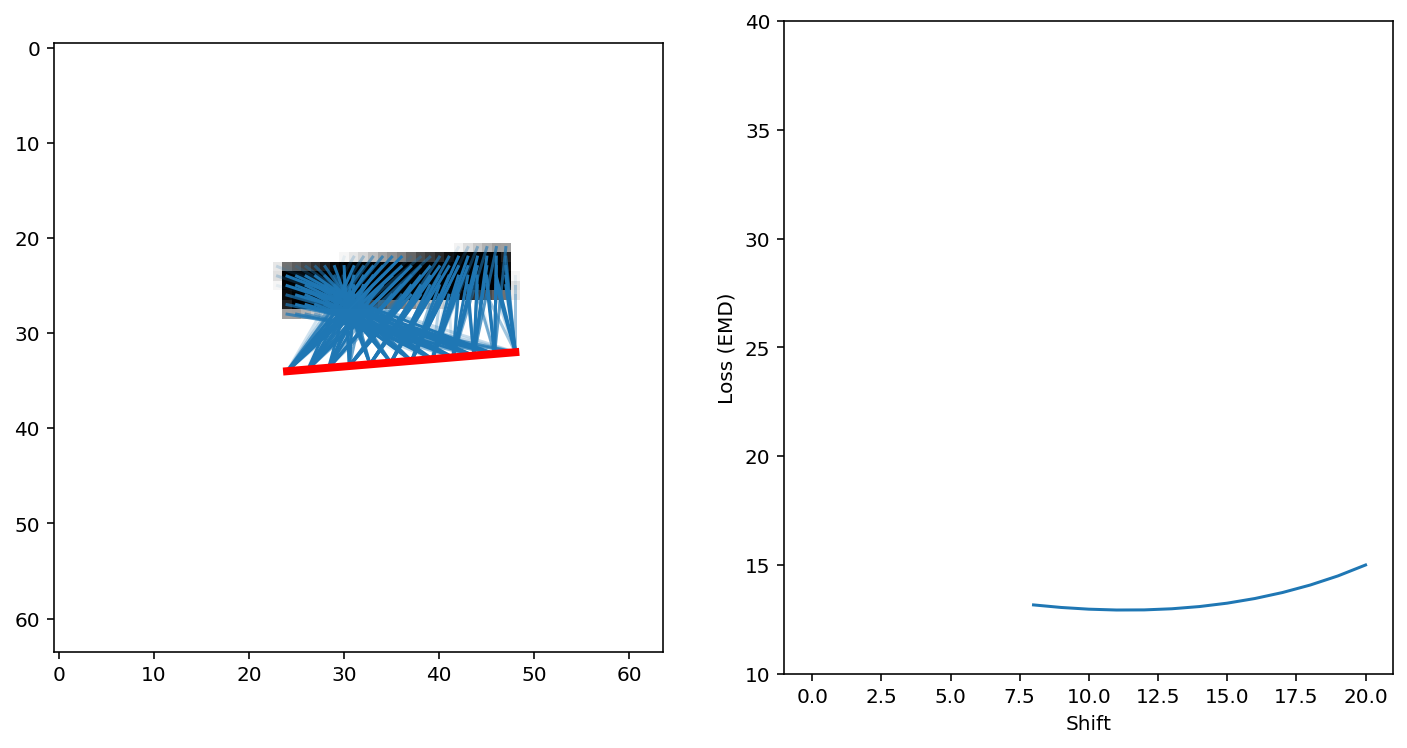

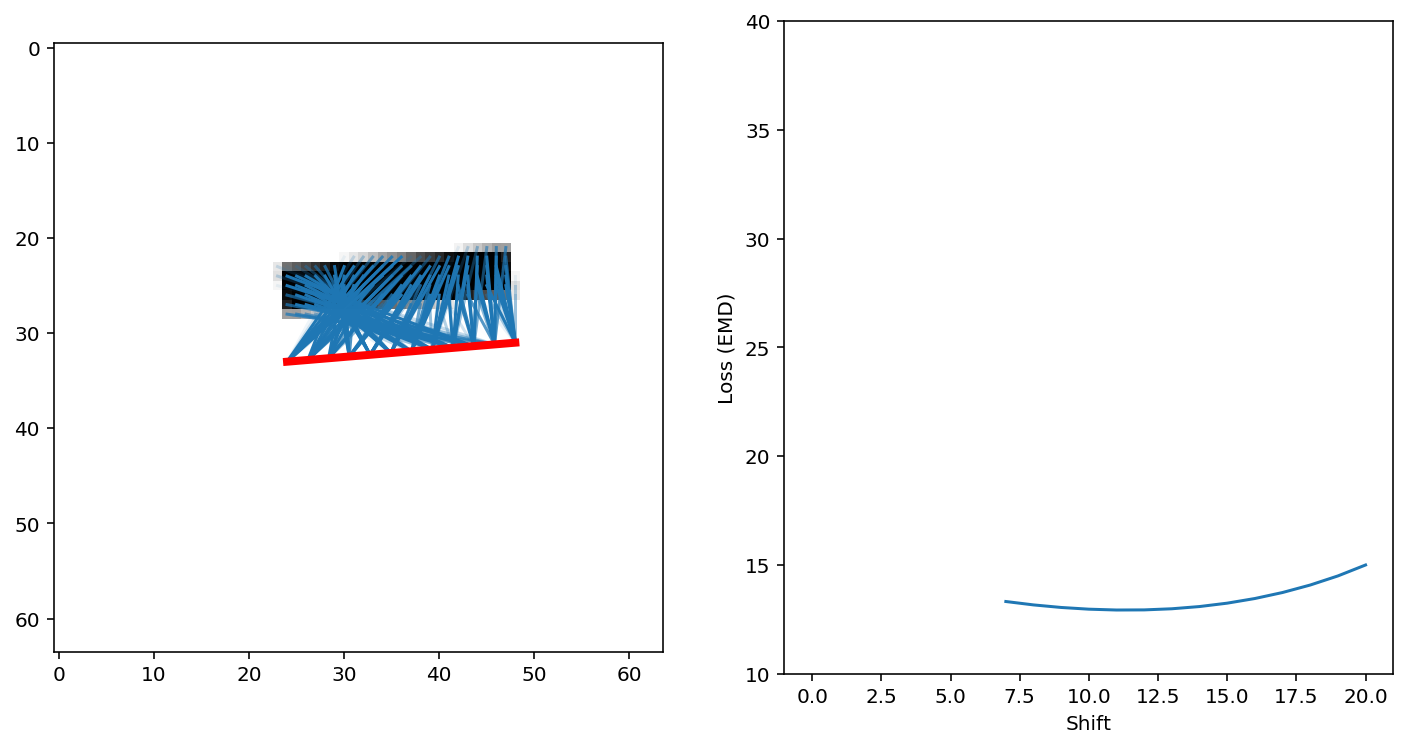

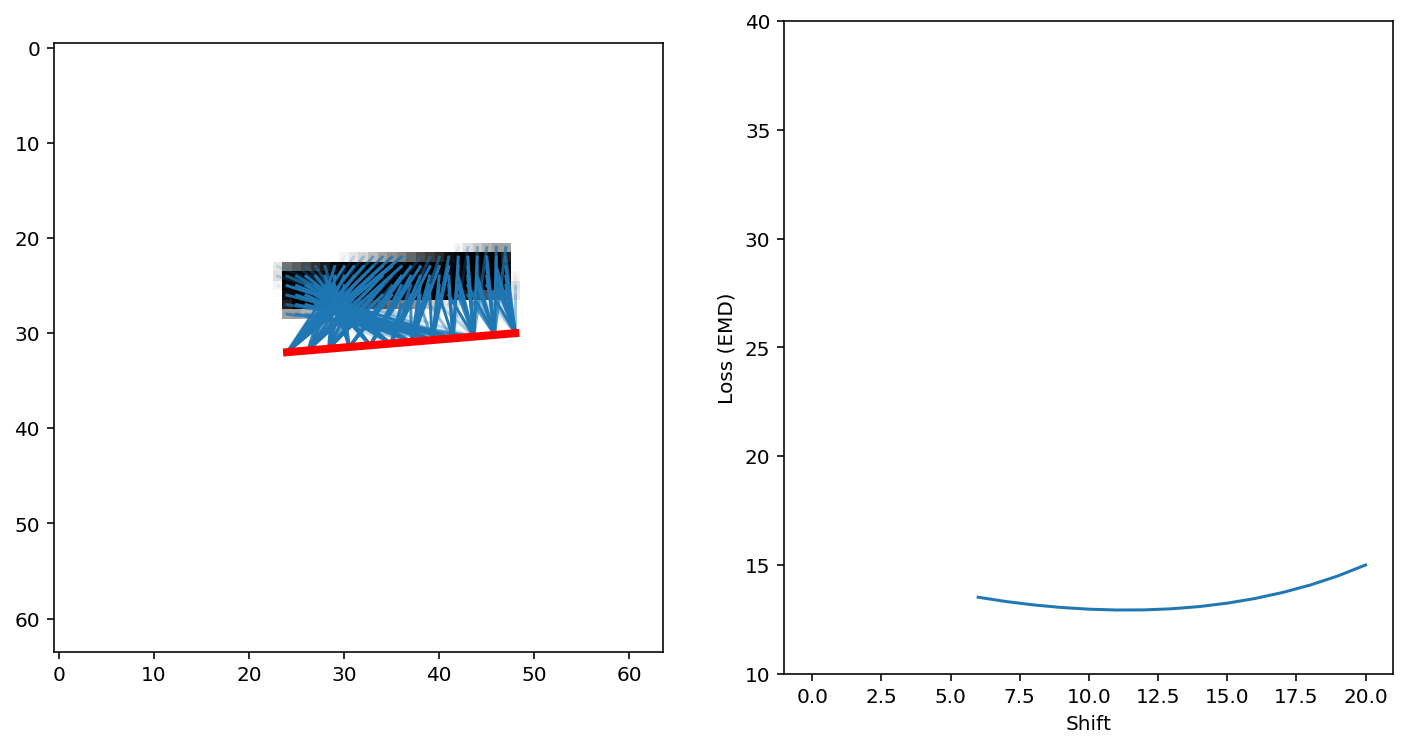

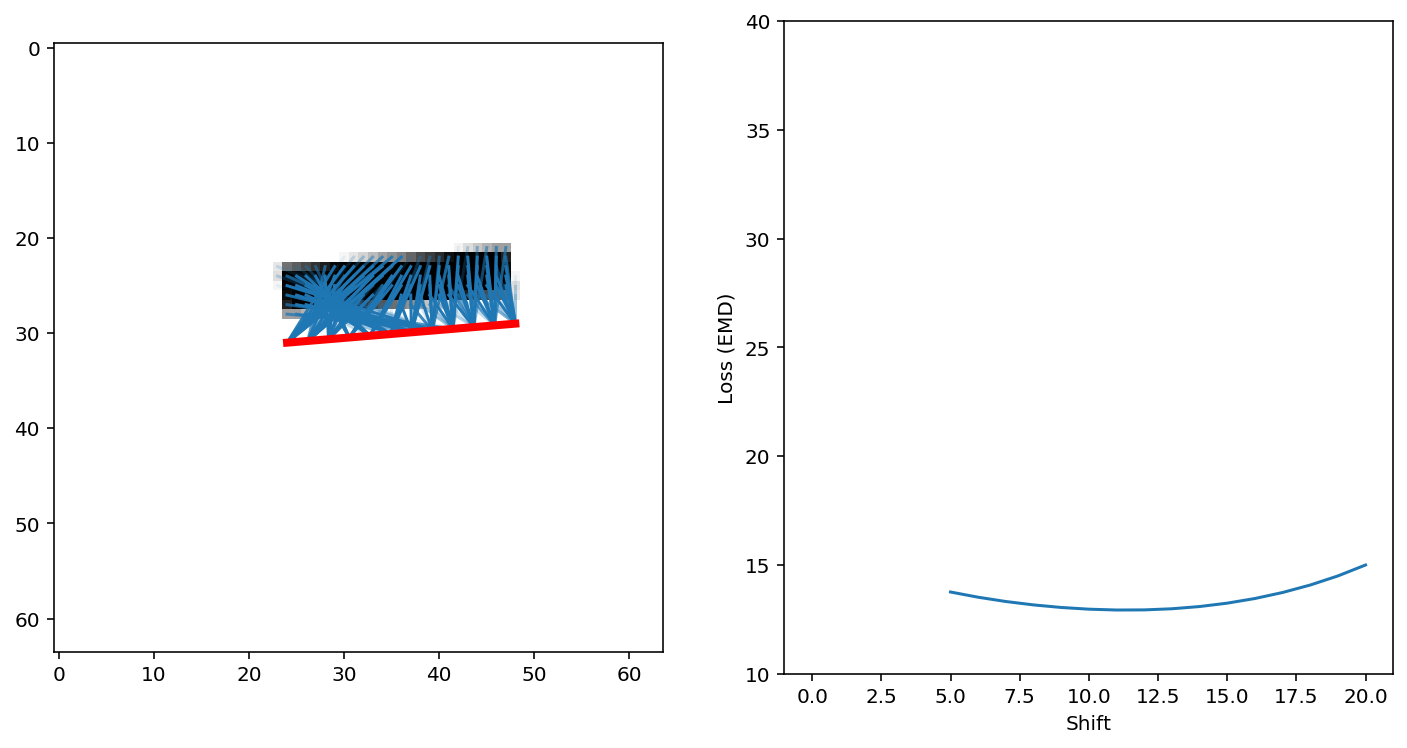

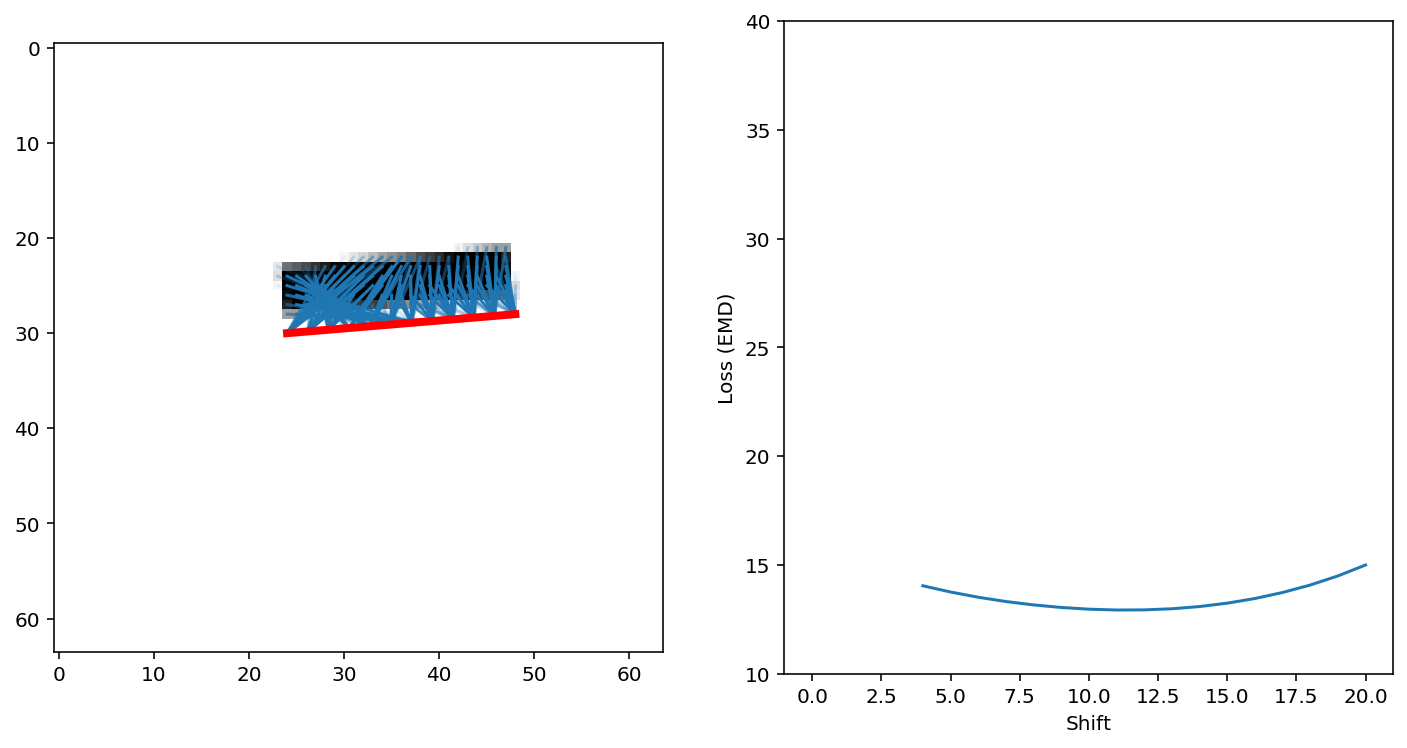

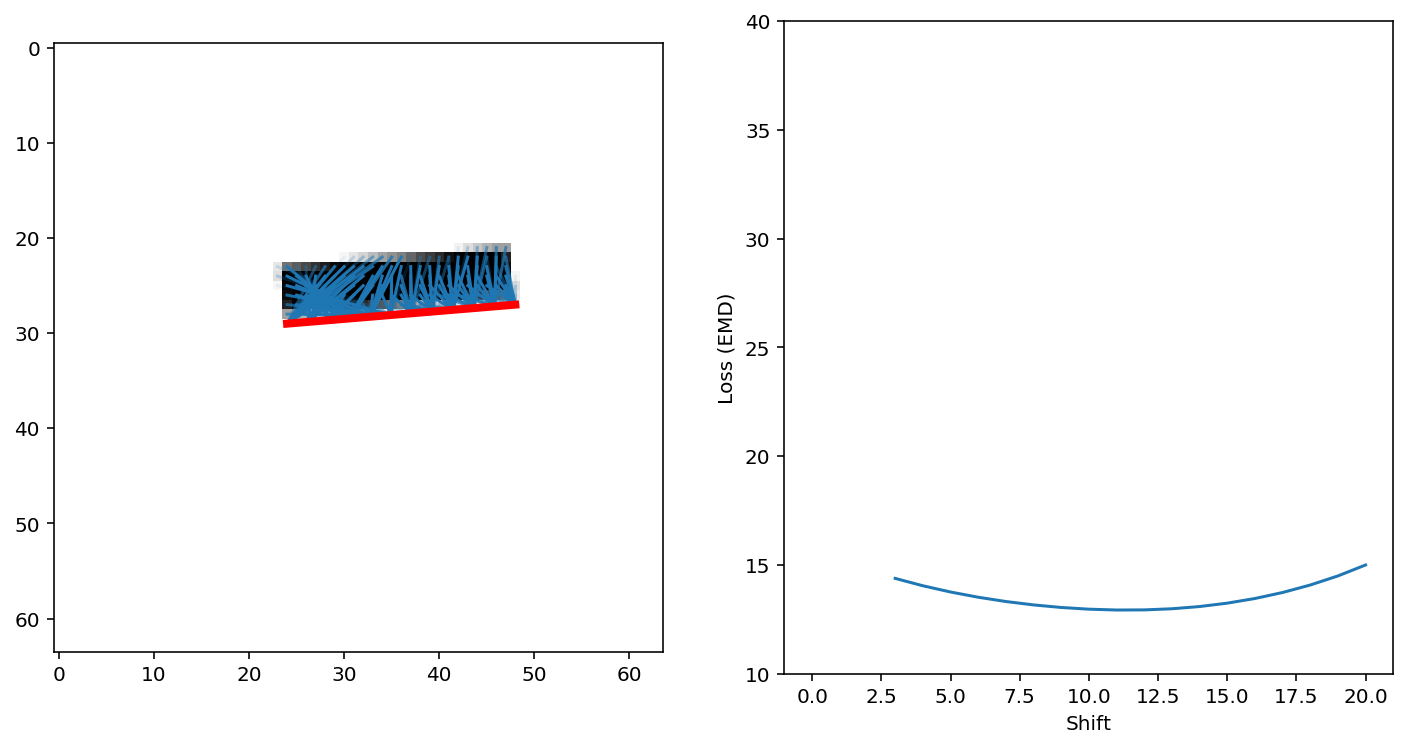

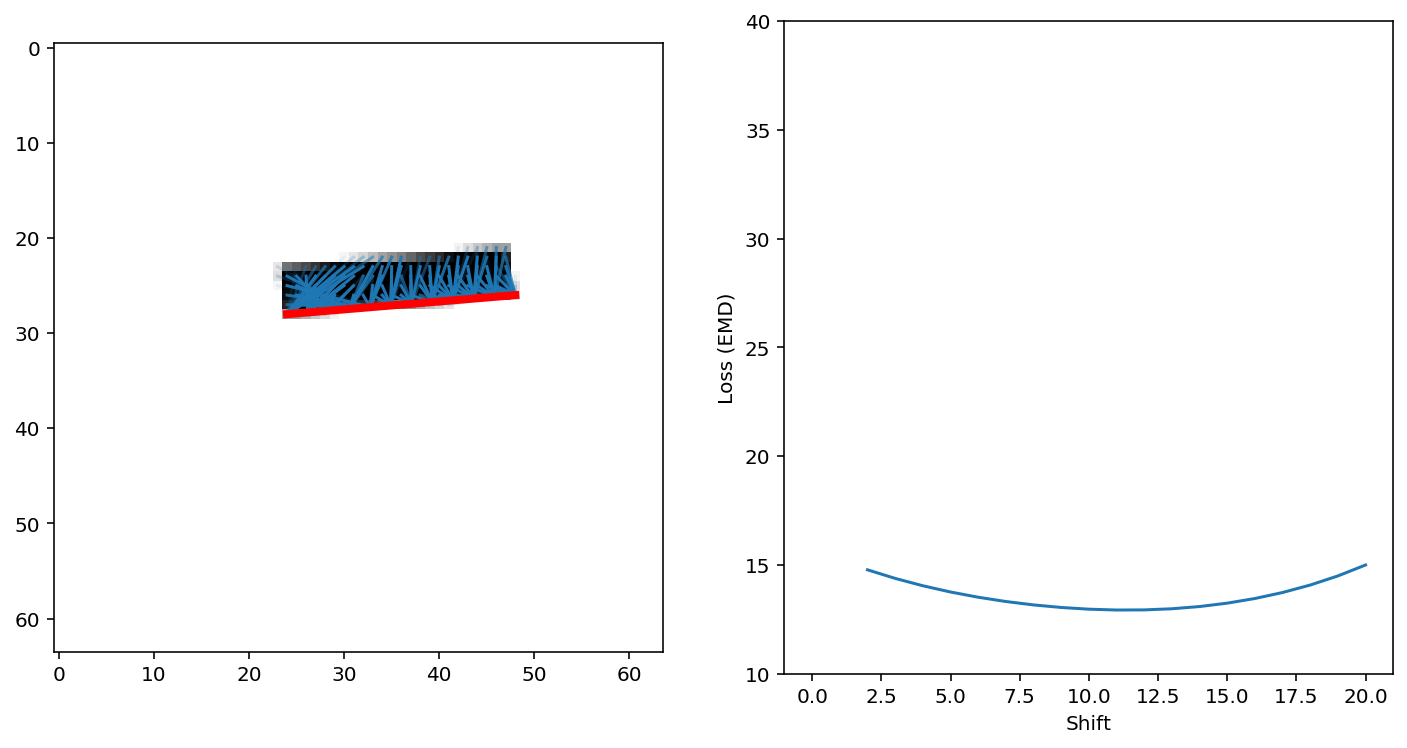

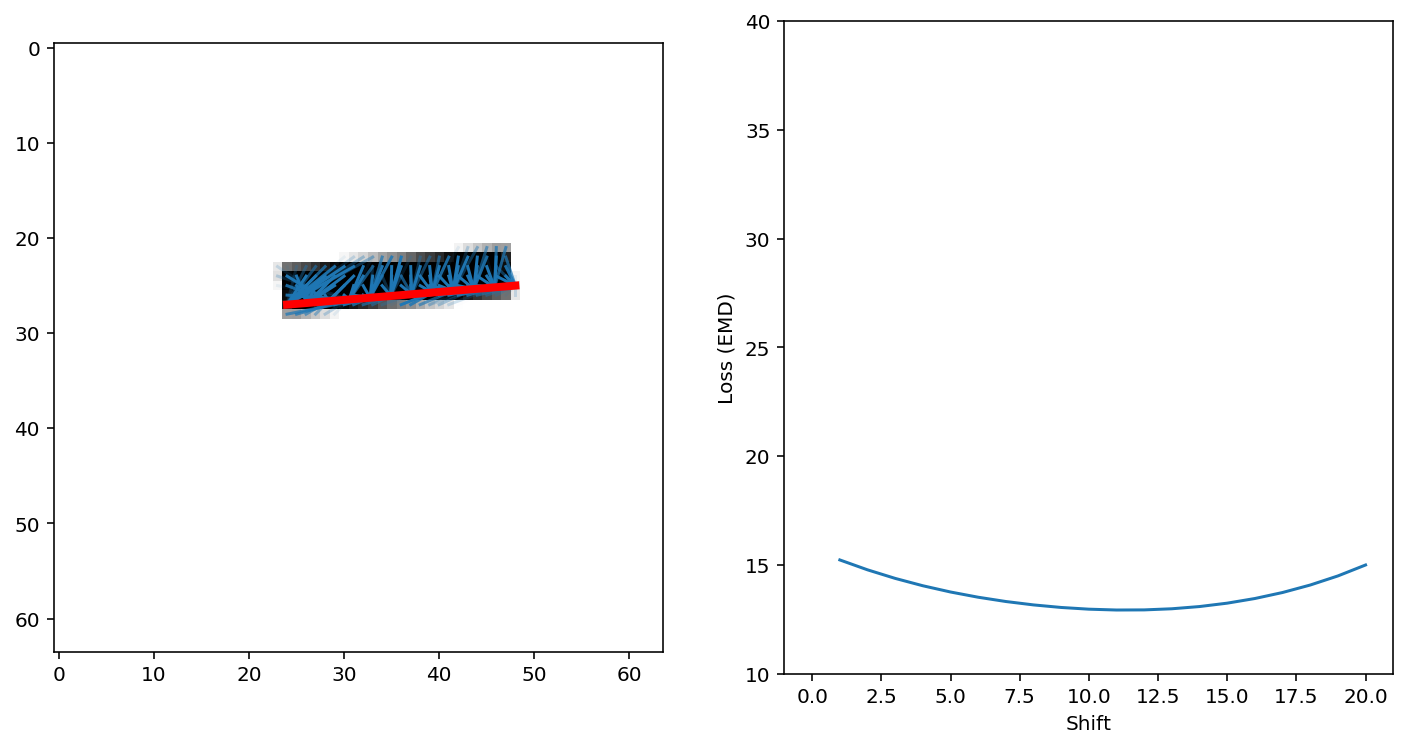

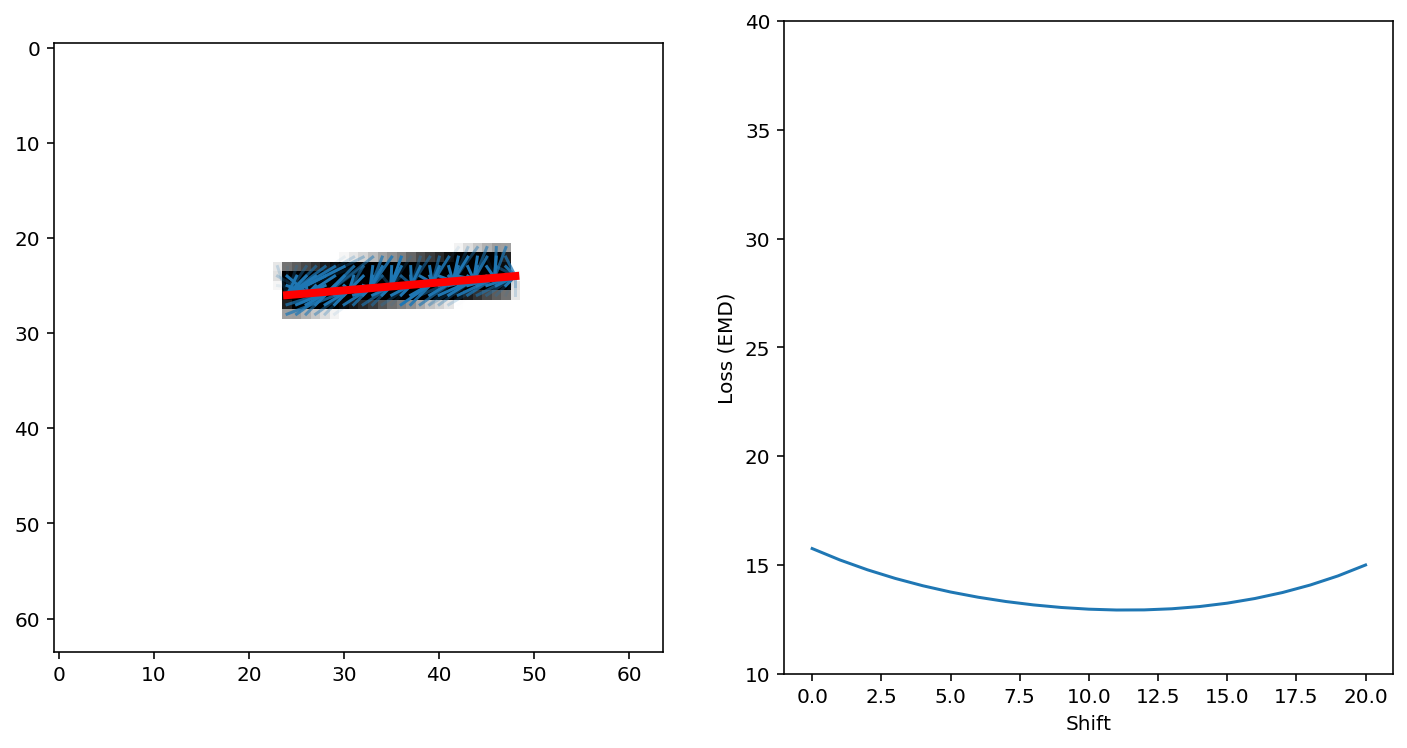

In [12]:
lambd = 0.001
n_points_per_line = 12

losses = []

for step, x_shift in enumerate(range(20, -1, -1)):
    
    plines = shift_lines(lines, 0, x_shift)
    
    line_coords, line_masses = spread_masses(plines, n_points_per_line=n_points_per_line)
    line_masses /= np.sum(line_masses)
    
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)
    
    distance_matrix = ot.dist(line_coords, pixel_coords, 'euclidean')
    transport_matrix = ot.emd(line_masses, pixel_density, distance_matrix)
    loss = ot.emd2(line_masses, pixel_density, distance_matrix)
    print(loss)
    losses.append(loss)
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Loss: {loss}')
    
    plt.subplot(121)
    plt.imshow(image, cmap='gray_r')

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            plt.plot([line_coords[i][0], pixel_coords[j][1]], [line_coords[i][1], pixel_coords[j][0]], 
                     alpha=20 * transport_matrix[i, j] / transport_matrix[i].sum(),
                     color=f'C{i // n_points_per_line}')

    for x0, y0, x1, y1, width in plines:
        plt.plot([x0, x1], [y0, y1], linewidth=4, color='red')
        
    plt.subplot(122, ylabel='Loss (EMD)', xlabel='Shift', autoscaley_on=True)
    plt.xlim(-1, 21)
    plt.ylim(10, 40)
    plt.plot(np.arange(20, 20 - step - 1, -1), losses)
    
#     plt.savefig(f'ot_emd_{step}.png', dpi=300)

    plt.show()